# ***大衛．卓曼(David Dreman)逆向投資策略***

## 策略簡介

David Dreman 是逆向投資（Contrarian Investing）領域的先驅，其投資哲學強調在市場過度悲觀時買入被低估的價值股。本策略基於 Dreman 的選股原則，透過系統化篩選**低本益比**、**高股息**、**財務穩健**的價值股，在台灣股市實現長期穩定報酬。

### 核心選股邏輯（兩階段篩選）

**階段一：核心條件（必須全部符合）**

1. 市值 ≥ 市場平均（排除極小型股）
2. 本益比 ≤ 50% 分位數 且 ≤ 市場平均
3. 股息收益率 ≥ 市場平均

**階段二：額外條件（計分制，至少 3 分）**

4. 流動比率 ≥ 市場平均 → +1 分
5. 負債淨值比 ≤ 市場平均 → +1 分
6. ROE > 0 且 ≥ 正值平均 → +1 分
7. 稅前淨利率 > 0 且 ≥ 正值平均 → +1 分
8. 盈餘成長率 ≥ 市場平均 → +1 分

### 回測設定

- **投資標的**：台灣證券交易所上市普通股
- **回測期間**：2020-01-01 ～ 2025-09-30
- **基準指數**：台灣加權報酬指數（IR0001）
- **再平衡頻率**：每季（3、6、9、12 月最後交易日）
- **初始資金**：1,000 萬元

---

## 1. 環境設定與套件載入

**注意事項**：
- 本策略需要使用 `python-dotenv` 套件來載入環境變數，請先安裝：
  ```bash
  pip install python-dotenv
  ```
- 請在專案根目錄建立 `.env` 檔案，並設定 TEJ API 金鑰：
  ```
  TEJAPI_KEY=your_api_key_here
  TEJAPI_BASE=your_api_base_url_here
  ```

In [10]:
import os
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from dotenv import load_dotenv
load_dotenv()

# TEJ API 設定
import tejapi
tejapi.ApiConfig.api_key = os.getenv('TEJAPI_KEY')
os.environ['TEJAPI_KEY'] = os.getenv('TEJAPI_KEY')
tejapi.ApiConfig.api_base = os.getenv('TEJAPI_BASE')
os.environ['TEJAPI_BASE'] = os.getenv('TEJAPI_BASE')

# 設定
warnings.filterwarnings('ignore')
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei', 'Arial']
plt.rcParams['axes.unicode_minus'] = False

## 2. 回測期間設定

In [11]:
start_date = '2019-12-29'
end_date = '2025-09-30'

## 3. 股票池設定

從台灣證券交易所（TSE）取得所有上市普通股作為選股範圍。

In [12]:
from zipline.sources.TEJ_Api_Data import get_universe

pool = get_universe(
    start=pd.Timestamp(start_date, tz='utc'), 
    end=pd.Timestamp(end_date, tz='utc'), 
    mkt_bd_e=['TSE'],
    stktp_e='Common Stock'
)

print(f"股票池總數: {len(pool)} 檔")

Currently used TEJ API key call quota 525/1000000 (0.05%)
Currently used TEJ API key data quota 48671557/100000000 (48.67%)
股票池總數: 970 檔


## 4. 財報數據獲取

取得策略所需的財務指標，包括：
- 市值、本益比、股息收益率
- 流動資產/負債、總負債/權益
- ROE、稅前淨利率
- 每股盈餘、流通在外股數

In [13]:
import TejToolAPI

columns = [
    'mktcap',   # 市值
    'per',      # 本益比
    'div_yid',  # 股息收益率
    'bsca',     # 流動資產
    'bscl',     # 流動負債
    'bstl',     # 總負債
    'bsse',     # 總權益
    'r16a',     # 股息支出率
    'r104',     # ROE
    'r107',     # 稅前淨利率
    'eps',      # 每股盈餘
    'shares',   # 流通在外股數
    'r405'      # 盈餘成長率
]

data__ = TejToolAPI.get_history_data(
    start=pd.Timestamp(start_date, tz='UTC'), 
    end=pd.Timestamp(end_date, tz='UTC'), 
    ticker=pool, 
    fin_type='Q', 
    columns=columns, 
    transfer_to_chinese=True
)

print(f"數據筆數: {len(data__):,}")
print(f"日期範圍: {data__['日期'].min().date()} ~ {data__['日期'].max().date()}")

Currently used TEJ API key call quota 630/1000000 (0.06%)
Currently used TEJ API key data quota 51644204/100000000 (51.64%)
數據筆數: 1,262,426
日期範圍: 2019-12-30 ~ 2025-09-30


## 5. 計算再平衡日期

策略於每季最後交易日（3、6、9、12 月）重新選股並調整持倉。

In [ ]:
# 使用 TEJ 交易日曆抓取每季最後交易日
# 比用個股股價更穩健，不會因暫停交易而遺漏日期
trade_days = tejapi.get(
    'TWN/TRADEDAY_TWSE',
    zdate={'gte': start_date, 'lte': end_date},
    tradeday_cno={'ne': 0}  # 只抓取交易日
)

# 轉換日期格式
trade_days['zdate'] = pd.to_datetime(trade_days['zdate'])
trade_days['year'] = trade_days['zdate'].dt.year
trade_days['month'] = trade_days['zdate'].dt.month

# 找出每季最後交易日（3、6、9、12 月）
rebalance_months = [3, 6, 9, 12]
modified_day = []

for month in rebalance_months:
    month_data = trade_days[trade_days['month'] == month]
    last_days = month_data.groupby('year')['zdate'].max()
    modified_day.extend(last_days.tolist())

# 轉換為 date 格式並排序
modified_day = sorted([d.date() for d in modified_day])

print(f"再平衡次數: {len(modified_day)}")
print(f"範例日期: {modified_day[:8]}")

再平衡次數: 24
範例日期: [datetime.date(2019, 12, 31), datetime.date(2020, 3, 31), datetime.date(2020, 6, 30), datetime.date(2020, 9, 30), datetime.date(2020, 12, 31), datetime.date(2021, 3, 31), datetime.date(2021, 6, 30), datetime.date(2021, 9, 30)]


## 6. 選股函數定義

核心選股邏輯：
1. **核心條件**：市值、本益比、股息收益率（全部符合）
2. **額外條件**：流動比率、負債淨值比、ROE、淨利率、盈餘成長（至少 3 項符合）
3. **動態降級**：若無股票符合，自動降低至 2 項額外條件

In [15]:
def compute_stock(date, data, verbose=True):
    """
    David Dreman 逆向投資選股函數
    
    參數:
    - date: 選股日期
    - data: 財報數據
    - verbose: 是否顯示詳細訊息
    
    回傳:
    - 入選股票代碼列表
    """
    df = data[data['日期'] == pd.Timestamp(date)].reset_index(drop=True)
    
    if len(df) == 0:
        if verbose:
            print(f"警告：{date} 無數據")
        return []

    # 計算衍生指標
    df['流動比率'] = df['流動資產合計_Q'] / df['流動負債合計_Q']
    df['負債淨值比'] = df['負債總額_Q'] / df['股東權益總計_Q']
    
    # 計算市場平均值
    avg_mktcap = df['個股市值_元'].mean(skipna=True)
    avg_per = df['本益比'].mean(skipna=True)
    avg_div_yield = df['股利殖利率'].mean(skipna=True)
    avg_current_ratio = df['流動比率'].mean(skipna=True)
    avg_debt_equity = df['負債淨值比'].mean(skipna=True)
    
    # ROE 和稅前淨利率：只對正值計算平均
    valid_roe = df[df['常續ROE_Q'] > 0]['常續ROE_Q']
    avg_roe = valid_roe.mean() if len(valid_roe) > 0 else 0
    
    valid_profit_margin = df[df['稅前淨利率_Q'] > 0]['稅前淨利率_Q']
    avg_profit_margin = valid_profit_margin.mean() if len(valid_profit_margin) > 0 else 0
    
    # 盈餘成長率：使用 TEJ 提供的 r405 欄位（盈餘年成長率）
    # 如果沒有 r405，則用 EPS 計算（按公司分組）
    if '盈餘年成長率_Q' in df.columns:
        avg_earnings_growth = df['盈餘年成長率_Q'].mean(skipna=True)
    else:
        # 備用方案：按股票代碼分組計算 EPS 成長率
        df = df.sort_values(['股票代碼', '日期'])
        df['EPS成長率'] = df.groupby('股票代碼')['母公司每股盈餘_Q'].pct_change(periods=4)
        avg_earnings_growth = df['EPS成長率'].mean(skipna=True)

    if verbose:
        print(f"\n========== {date} 選股 ==========")
        print(f"總股票數: {len(df)}")
    
    # ========== 階段一：核心條件 ==========
    # 條件1: 市值
    set_1 = set(df[df['個股市值_元'] >= avg_mktcap]['股票代碼'])
    
    # 條件2: 本益比（50% 分位數）
    df_valid_per = df[df['本益比'] > 0]
    if len(df_valid_per) > 0:
        per_threshold = df_valid_per['本益比'].quantile(0.5)
        set_2 = set(df[
            (df['本益比'] <= per_threshold) & 
            (df['本益比'] <= avg_per) & 
            (df['本益比'] > 0)
        ]['股票代碼'])
    else:
        set_2 = set()
    
    # 條件3: 股息收益率
    set_3 = set(df[df['股利殖利率'] >= avg_div_yield]['股票代碼'])
    
    # 核心條件交集
    core_set = set_1 & set_2 & set_3
    
    # ========== 階段二：額外條件（計分制）==========
    set_4 = set(df[df['流動比率'] >= avg_current_ratio]['股票代碼'])
    set_5 = set(df[df['負債淨值比'] <= avg_debt_equity]['股票代碼'])
    set_7 = set(df[(df['常續ROE_Q'] > 0) & (df['常續ROE_Q'] >= avg_roe)]['股票代碼'])
    set_8 = set(df[(df['稅前淨利率_Q'] > 0) & (df['稅前淨利率_Q'] >= avg_profit_margin)]['股票代碼'])
    
    # 盈餘成長率條件
    if '盈餘年成長率_Q' in df.columns:
        set_9 = set(df[df['盈餘年成長率_Q'] >= avg_earnings_growth]['股票代碼'])
    else:
        set_9 = set(df[df['EPS成長率'] >= avg_earnings_growth]['股票代碼'])
    
    if verbose:
        print(f"核心條件通過: {len(core_set)} 檔")
    
    # 計分篩選（至少 3 分）
    min_extra_score = 3
    selected_tickers = []
    
    for ticker in core_set:
        score = 0
        if ticker in set_4: score += 1
        if ticker in set_5: score += 1
        if ticker in set_7: score += 1
        if ticker in set_8: score += 1
        if ticker in set_9: score += 1
        
        if score >= min_extra_score:
            selected_tickers.append(ticker)
    
    # 動態降級機制（降至 2 分）
    if len(selected_tickers) == 0:
        fallback_score = 2
        if verbose:
            print(f"降級至 {fallback_score} 分...")
        for ticker in core_set:
            score = 0
            if ticker in set_4: score += 1
            if ticker in set_5: score += 1
            if ticker in set_7: score += 1
            if ticker in set_8: score += 1
            if ticker in set_9: score += 1
            if score >= fallback_score:
                selected_tickers.append(ticker)
    
    if verbose:
        print(f"最終入選: {len(selected_tickers)} 檔")
        if len(selected_tickers) > 0:
            print(f"股票: {selected_tickers[:10]}")
        print("="*40)
    
    return selected_tickers

## 7. Zipline 數據準備

將股票池數據匯入 Zipline 回測引擎。

In [16]:
from zipline.data.run_ingest import simple_ingest

# 加入基準指數
pools = pool + ['IR0001']

print("正在準備 Zipline 資料...")
simple_ingest(
    name='tquant', 
    tickers=pools, 
    start_date=start_date.replace('-', ''), 
    end_date=end_date.replace('-', '')
)
print("資料準備完成！")

正在準備 Zipline 資料...
Now ingesting data.
End of ingesting tquant.
Please call function `get_bundle(start_dt = pd.Timestamp('20191229', tz = 'utc'),end_dt = pd.Timestamp('20250930' ,tz = 'utc'))` in `zipline.data.data_portal` to check data.
End of ingesting tquant.
Please call function `get_bundle(start_dt = pd.Timestamp('20191229', tz = 'utc'),end_dt = pd.Timestamp('20250930' ,tz = 'utc'))` in `zipline.data.data_portal` to check data.
Currently used TEJ API key call quota 637/1000000 (0.06%)
Currently used TEJ API key data quota 54186911/100000000 (54.19%)
資料準備完成！
Currently used TEJ API key call quota 637/1000000 (0.06%)
Currently used TEJ API key data quota 54186911/100000000 (54.19%)
資料準備完成！


## 8. Zipline 回測策略定義

定義回測的三個核心函數：
- `initialize()`: 初始化交易成本、滑價、基準指數
- `handle_data()`: 每日執行的交易邏輯
- `analyze()`: 回測結束後的績效分析與視覺化

In [17]:
from zipline.api import (
    set_slippage, 
    set_commission, 
    set_benchmark, 
    symbol, 
    record, 
    order_target_percent
)
from zipline.finance import commission, slippage

def initialize(context):
    """初始化函數：設定交易成本、滑價、基準"""
    # 滑價模型
    set_slippage(slippage.VolumeShareSlippage(volume_limit=1, price_impact=0.01))
    
    # 手續費模型
    set_commission(
        commission.Custom_TW_Commission(
            min_trade_cost=20,    # 最低手續費 20 元
            discount=1.0,         # 無折扣
            tax=0.003             # 證交稅 0.3%
        )
    )
    
    # 設定基準指數
    set_benchmark(symbol('IR0001'))
    
    # 初始化變數
    context.i = 0
    context.state = False
    context.order_tickers = []
    context.last_tickers = []


def handle_data(context, data):
    """每日執行函數：判斷是否需要調整持倉"""
    # 避免前視偏誤：在篩選股票下一交易日下單
    if context.state == True:
        print(f"下單日期: {data.current_dt.date()}, 入選股票數: {len(context.order_tickers)}")

        # 賣出不再持有的股票
        for ticker in context.last_tickers:
            if ticker not in context.order_tickers:
                order_target_percent(symbol(ticker), 0)
        
        # 買入新入選的股票（等權重）
        if len(context.order_tickers) > 0:
            target_weight = 1 / len(context.order_tickers)
            for ticker in context.order_tickers:
                order_target_percent(symbol(ticker), target_weight)
                curr = data.current(symbol(ticker), 'price')
                record(price=curr, days=context.i)
        
        context.last_tickers = context.order_tickers

    context.state = False
    backtest_date = data.current_dt.date()
    
    # 查看是否為再平衡日期
    for rebalance_date in modified_day:
        if backtest_date == rebalance_date:
            context.state = True
            # 執行選股
            context.order_tickers = compute_stock(
                date=backtest_date, 
                data=data__,
                verbose=True
            )
    
    context.i += 1


def analyze(context, perf):
    """分析函數：繪製績效圖表"""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)
    
    # 上圖：累積報酬（使用 Zipline 計算好的累積報酬）
    perf['algorithm_period_return'].plot(ax=ax1, label='策略報酬', linewidth=2, color='#2E86AB')
    perf['benchmark_period_return'].plot(ax=ax1, label='大盤報酬 (IR0001)', linewidth=2, alpha=0.7, color='#A23B72')
    ax1.set_title('David Dreman 逆向投資策略 vs 大盤', fontsize=16, fontweight='bold', pad=20)
    ax1.set_ylabel('累積報酬率', fontsize=12)
    ax1.legend(loc='upper left', fontsize=11)
    ax1.grid(True, alpha=0.3)
    ax1.axhline(0, color='black', linewidth=0.8, linestyle='--', alpha=0.5)
    
    # 下圖：投資組合價值
    perf['portfolio_value'].plot(ax=ax2, label='投資組合價值', color='#F18F01', linewidth=2)
    ax2.set_title('投資組合價值變化', fontsize=14, fontweight='bold', pad=15)
    ax2.set_xlabel('日期', fontsize=12)
    ax2.set_ylabel('價值（元）', fontsize=12)
    ax2.legend(loc='upper left', fontsize=11)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 儲存績效數據
    perf.to_csv(f"dreman_perf_{start_date}_{end_date}.csv")
    print(f"\n績效數據已儲存至: dreman_perf_{start_date}_{end_date}.csv")

## 9. 執行回測

開始執行完整回測，系統將：
1. 在每季末重新選股
2. 調整持倉至等權重配置
3. 計算交易成本與滑價
4. 記錄所有交易與績效指標

開始回測 David Dreman 逆向投資策略

========== 2019-12-31 選股 ==========
總股票數: 878
核心條件通過: 48 檔
最終入選: 10 檔
股票: ['2227', '9945', '1102', '6176', '2492', '2915', '3044', '1229', '1101', '2408']
下單日期: 2020-01-02, 入選股票數: 10

========== 2019-12-31 選股 ==========
總股票數: 878
核心條件通過: 48 檔
最終入選: 10 檔
股票: ['2227', '9945', '1102', '6176', '2492', '2915', '3044', '1229', '1101', '2408']
下單日期: 2020-01-02, 入選股票數: 10

========== 2020-03-31 選股 ==========
總股票數: 878
核心條件通過: 48 檔
最終入選: 8 檔
股票: ['2227', '8464', '2449', '1102', '2492', '3044', '2383', '1101']
下單日期: 2020-04-01, 入選股票數: 8

========== 2020-03-31 選股 ==========
總股票數: 878
核心條件通過: 48 檔
最終入選: 8 檔
股票: ['2227', '8464', '2449', '1102', '2492', '3044', '2383', '1101']
下單日期: 2020-04-01, 入選股票數: 8

========== 2020-06-30 選股 ==========
總股票數: 877
核心條件通過: 56 檔
最終入選: 9 檔
股票: ['2474', '8464', '1722', '9945', '2449', '2915', '9917', '3034', '2383']
下單日期: 2020-07-01, 入選股票數: 9

========== 2020-06-30 選股 ==========
總股票數: 877
核心條件通過: 56 檔
最終入選: 9 檔
股票: ['2474', '8464', '1722', '9

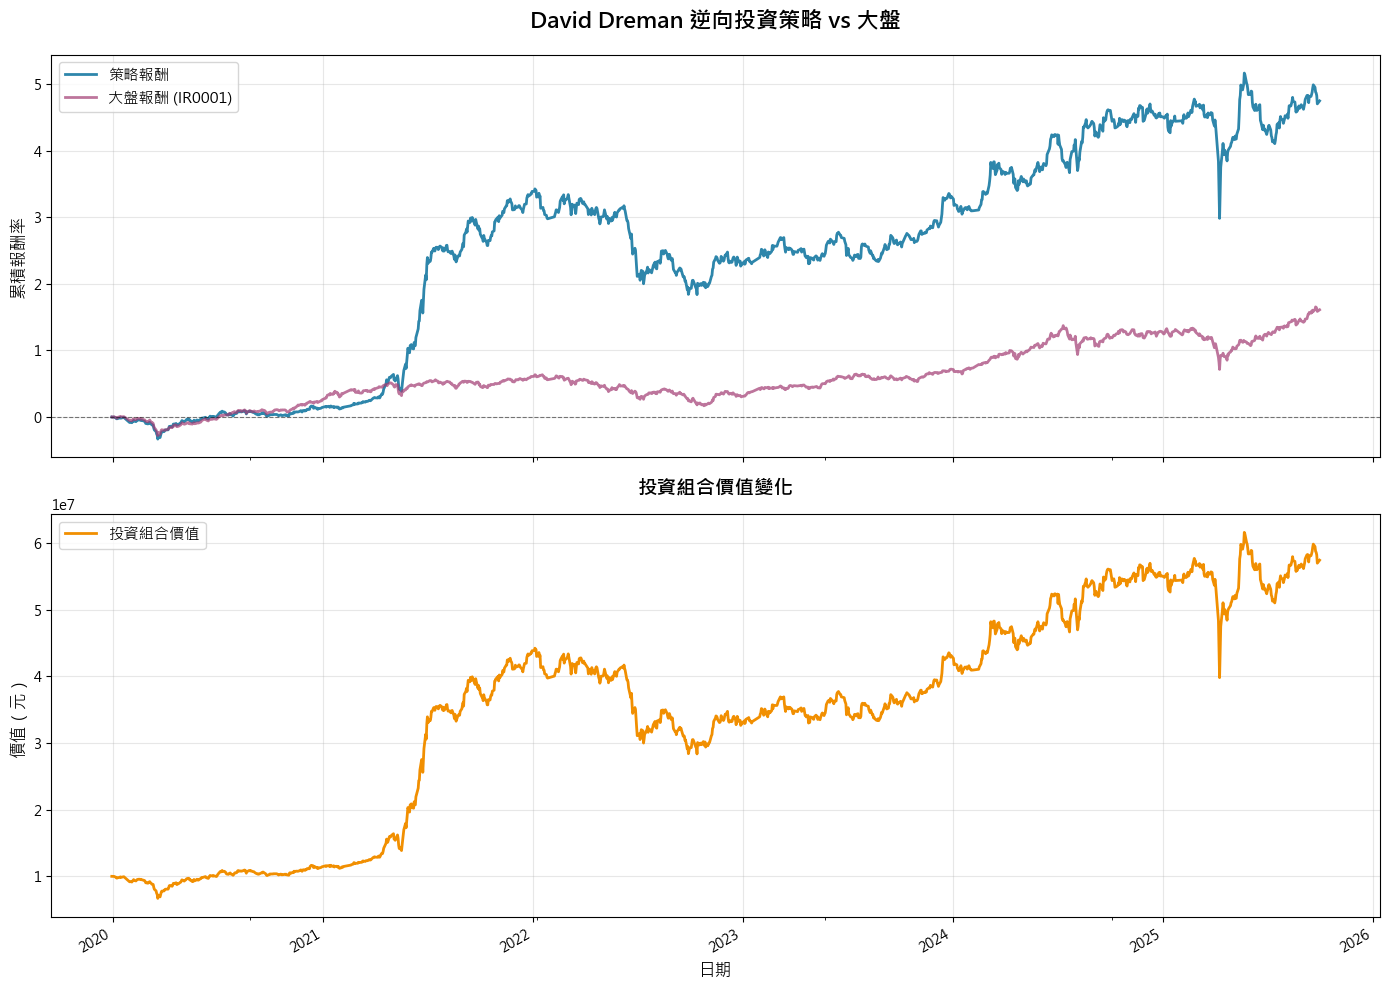


績效數據已儲存至: dreman_perf_2019-12-29_2025-09-30.csv

回測完成！


In [18]:
from zipline import run_algorithm

print("="*60)
print("開始回測 David Dreman 逆向投資策略")
print("="*60)

results = run_algorithm(
    start=pd.Timestamp(start_date, tz='utc'),
    end=pd.Timestamp(end_date, tz='utc'),
    initialize=initialize,
    handle_data=handle_data,
    analyze=analyze,
    bundle='tquant',
    capital_base=1e7  # 1000 萬元
)

print("\n回測完成！")

## 10. 績效統計摘要

計算策略的關鍵績效指標。

In [22]:
# 基礎績效統計（統一使用 Pyfolio 的計算方式）
total_return = results['algorithm_period_return'].iloc[-1]
benchmark_return = results['benchmark_period_return'].iloc[-1]
alpha = total_return - benchmark_return

# 計算年化報酬（使用交易日數除以 252）
years = len(results) / 252
annualized_return = (1 + total_return) ** (1 / years) - 1
annualized_benchmark = (1 + benchmark_return) ** (1 / years) - 1

# 計算最大回撤
cumulative = (1 + results['returns']).cumprod()
running_max = cumulative.expanding().max()
drawdown = (cumulative - running_max) / running_max
max_drawdown = drawdown.min()

# 計算波動率（年化）
volatility = results['returns'].std() * np.sqrt(252)

# 計算夏普比率（正確公式）
# 方法1: (年化報酬 - 無風險利率) / 年化波動率
risk_free_rate = 0.01  # 假設無風險利率 1%
sharpe_ratio = (annualized_return - risk_free_rate) / volatility

# 方法2: 使用日報酬計算（結果相同）
# sharpe_ratio = (results['returns'].mean() * 252 - risk_free_rate) / (results['returns'].std() * np.sqrt(252))

print("\n" + "="*60)
print("績效摘要")
print("="*60)
print(f"回測期間: {years:.2f} 年")
print(f"\n策略總報酬: {total_return*100:.2f}%")
print(f"基準總報酬: {benchmark_return*100:.2f}%")
print(f"超額報酬 (Alpha): {alpha*100:.2f}%")
print(f"\n策略年化報酬: {annualized_return*100:.2f}%")
print(f"基準年化報酬: {annualized_benchmark*100:.2f}%")
print(f"\n最大回撤: {max_drawdown*100:.2f}%")
print(f"年化波動率: {volatility*100:.2f}%")
print(f"夏普比率: {sharpe_ratio:.3f}")
print(f"  (假設無風險利率: {risk_free_rate*100:.2f}%)")
print(f"\n最終資產: {results['portfolio_value'].iloc[-1]:,.0f} 元")
print("="*60)


績效摘要
回測期間: 5.55 年

策略總報酬: 474.60%
基準總報酬: 160.99%
超額報酬 (Alpha): 313.61%

策略年化報酬: 37.02%
基準年化報酬: 18.86%

最大回撤: -35.87%
年化波動率: 27.10%
夏普比率: 1.329
  (假設無風險利率: 1.00%)

最終資產: 57,460,408 元


## 11. Pyfolio 詳細分析（選用）

使用 Pyfolio 套件生成完整的績效分析報告，包括：
- 報酬分析
- 風險指標
- 持倉分析
- 交易統計

Start date,2019-12-30
End date,2025-09-30
Total months,66
,Backtest
Annual return,37.02%
Cumulative returns,474.604%
Annual volatility,27.1%
Sharpe ratio,1.30
Calmar ratio,1.03
Stability,0.76
Max drawdown,-35.873%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,35.87,2022-01-04,2022-10-13,2024-03-04,521
1,33.09,2020-01-02,2020-03-19,2020-06-18,110
2,31.01,2025-02-24,2025-04-09,2025-05-15,55
3,17.18,2025-05-22,2025-07-14,NaT,NaN
4,15.39,2021-05-03,2021-05-17,2021-05-21,15


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the foll

Top 10 long positions of all time,max
sid,
2615,76.04%
9945,43.12%
2915,41.92%
6239,36.55%
3008,35.63%
2227,34.05%
2458,33.61%
8464,31.62%
2492,27.47%


Top 10 short positions of all time,max
sid,


Top 10 positions of all time,max
sid,
2615,76.04%
9945,43.12%
2915,41.92%
6239,36.55%
3008,35.63%
2227,34.05%
2458,33.61%
8464,31.62%
2492,27.47%


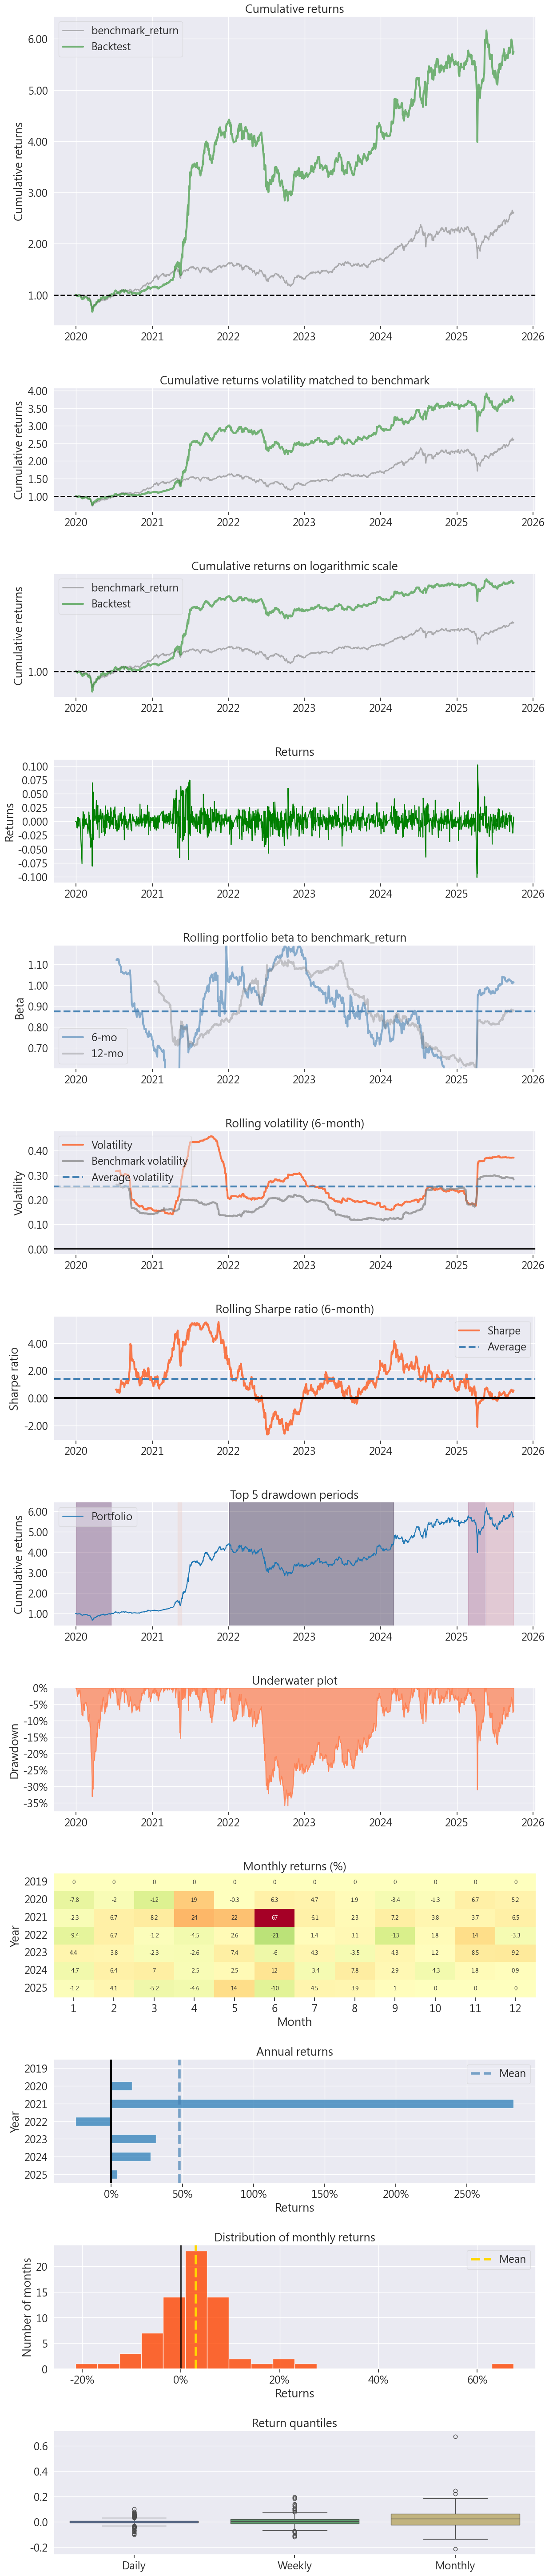

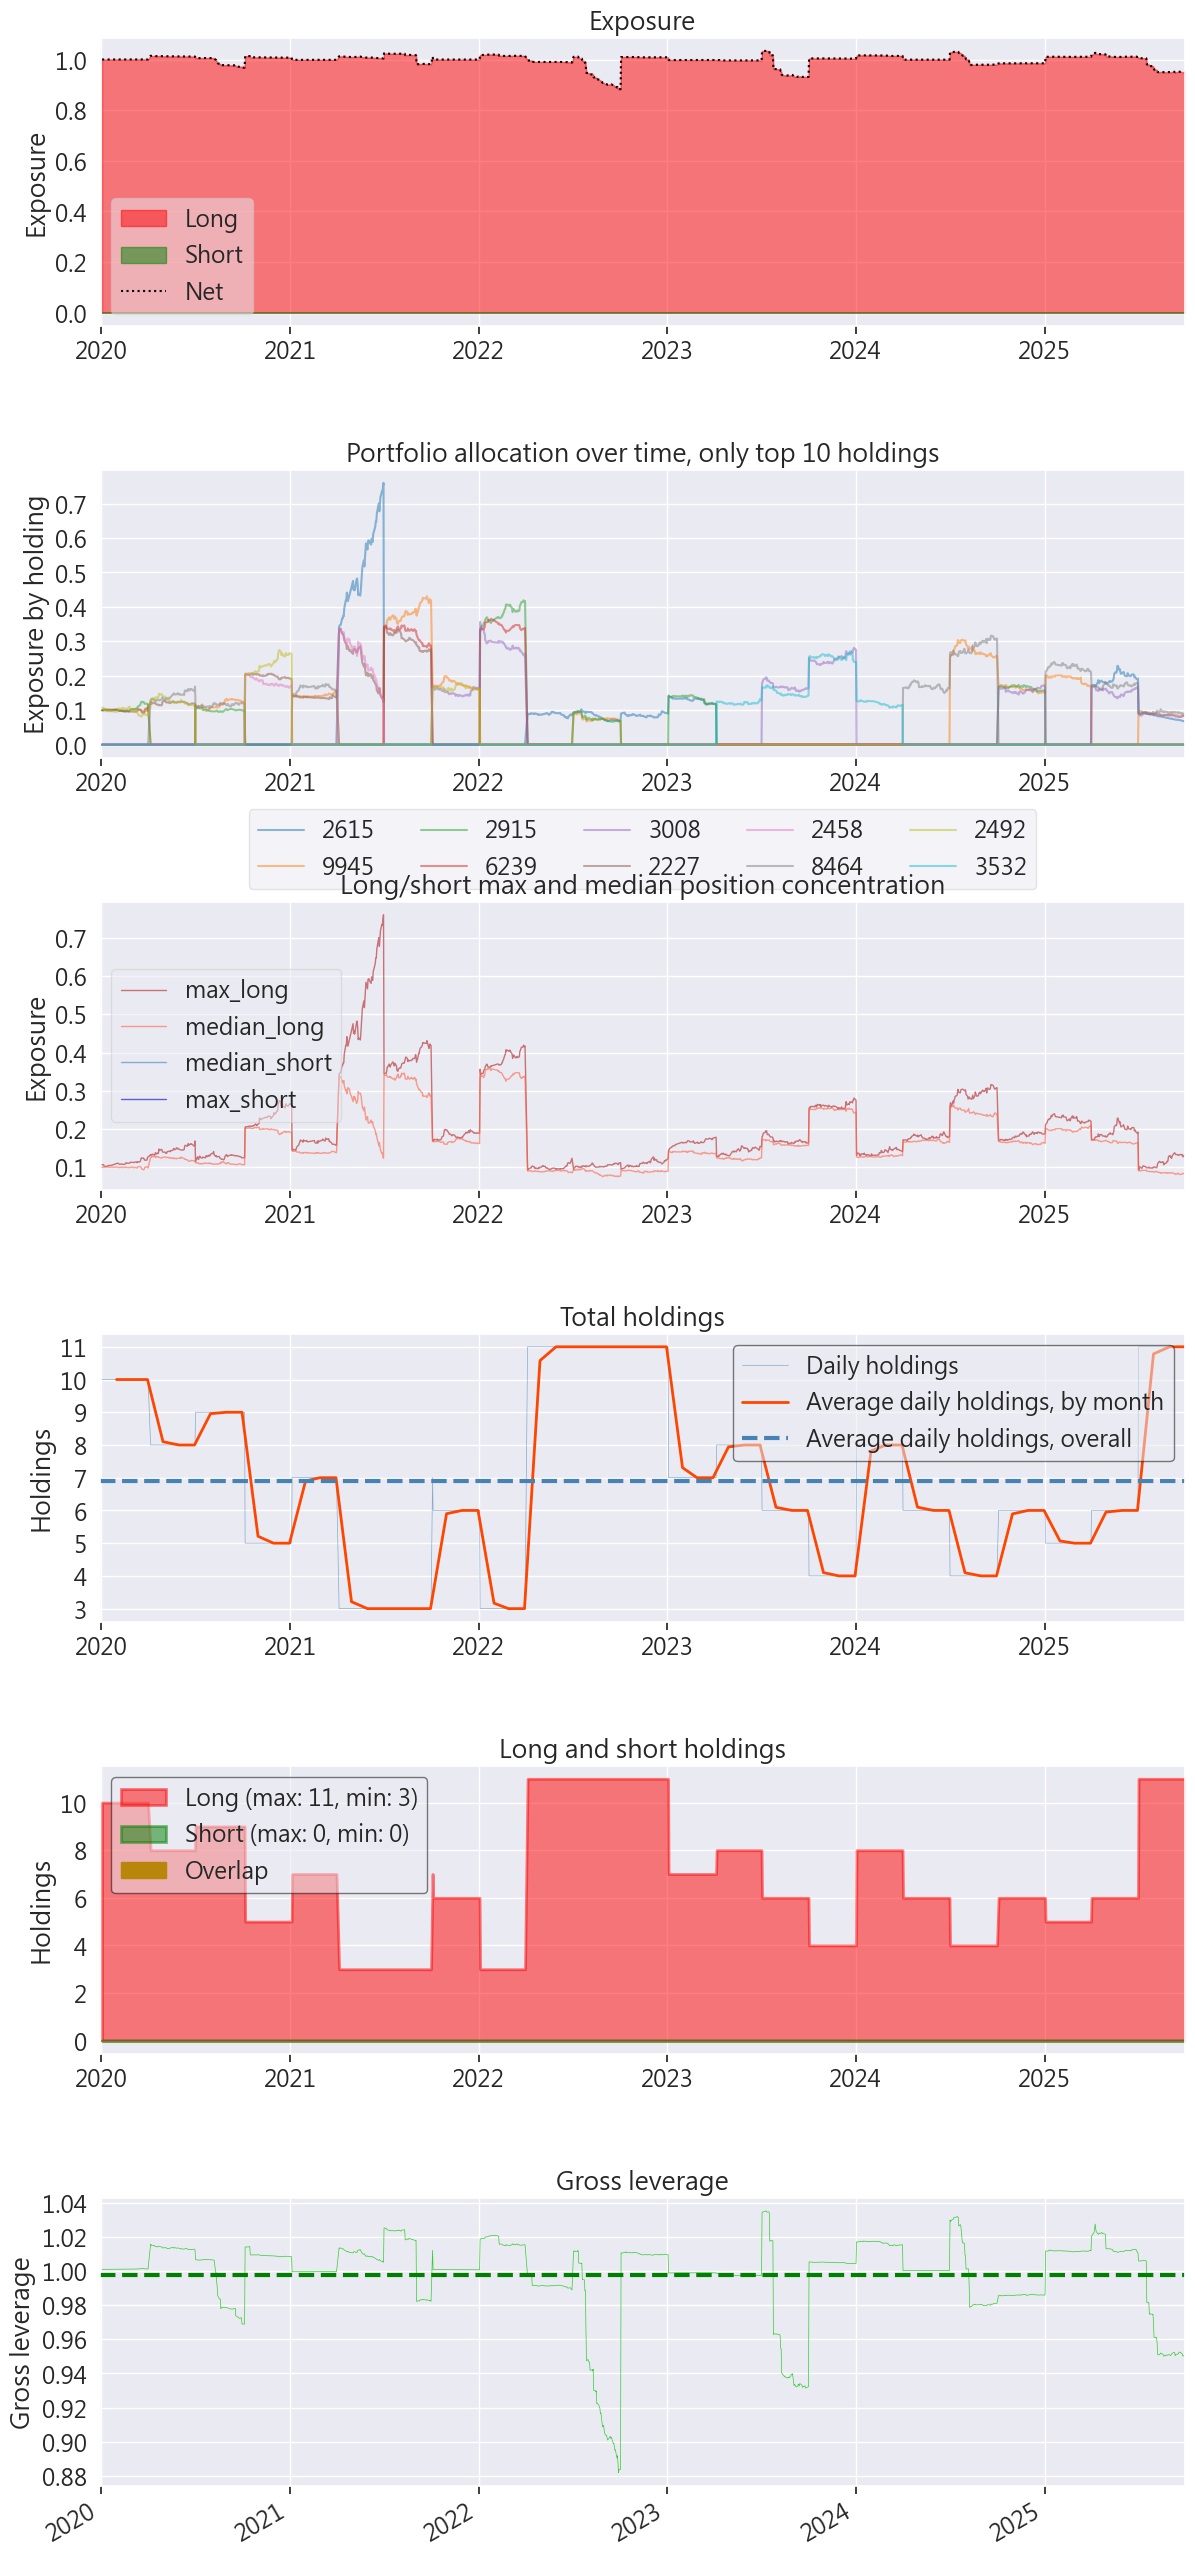

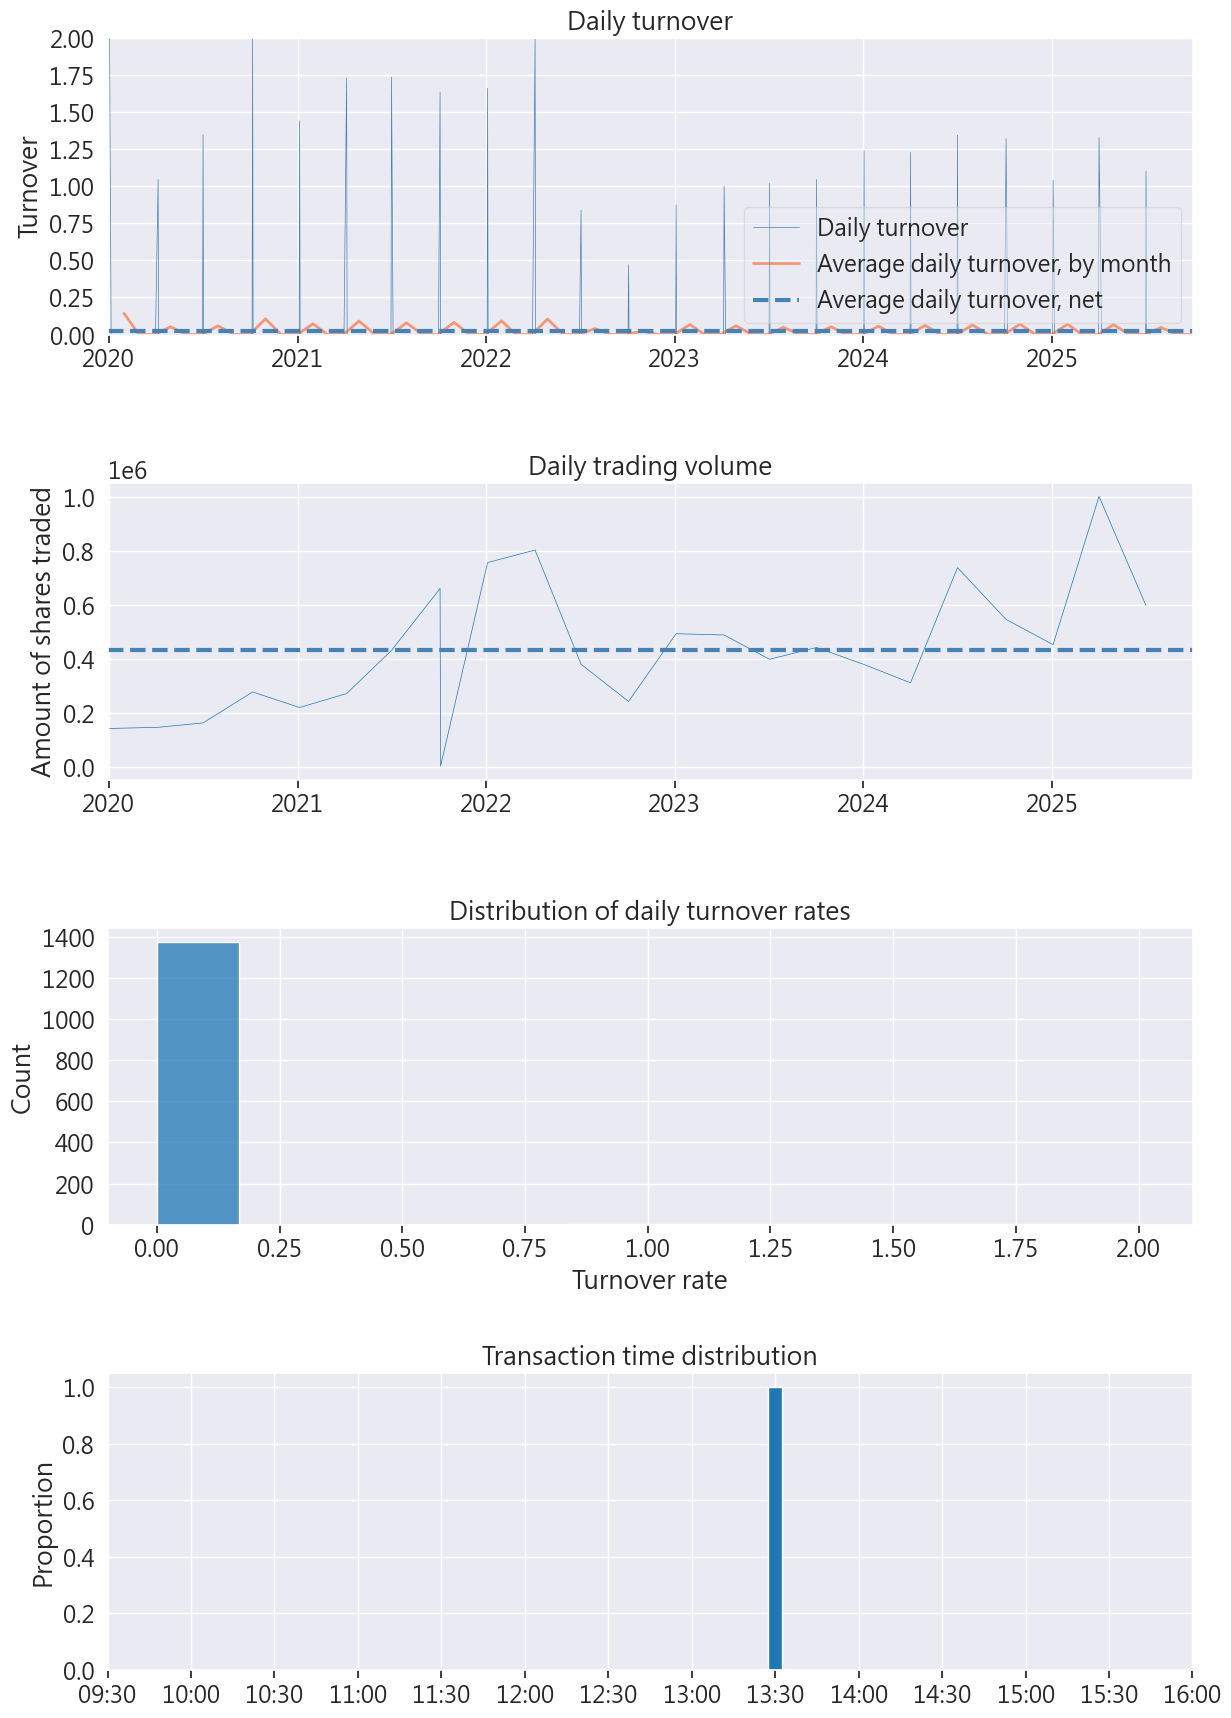

In [20]:
try:
    import pyfolio as pf
    from pyfolio.utils import extract_rets_pos_txn_from_zipline
    
    # 提取報酬、持倉、交易數據
    returns, positions, transactions = extract_rets_pos_txn_from_zipline(results)
    
    # 獲取基準報酬
    benchmark_rets = results.benchmark_return
    
    # 生成完整績效報告
    pf.tears.create_full_tear_sheet(
        returns=returns,
        positions=positions,
        transactions=transactions,
        benchmark_rets=benchmark_rets
    )
    
except ImportError:
    print("未安裝 pyfolio，略過詳細分析")
    print("若需完整報告，請執行: pip install pyfolio")
except Exception as e:
    print(f"Pyfolio 分析錯誤: {e}")

## 策略總結

### 核心特色

1. **系統化價值投資**：量化 Dreman 的選股原則，避免主觀判斷
2. **兩階段篩選**：確保入選公司同時具備價值特徵與財務穩健性
3. **彈性風控機制**：動態調整標準，避免極端市場下無股票可選
4. **適應台灣市場**：
   - 季度再平衡（配合財報公布節奏）
   - 排除極小型股（流動性考量）
   - 高股息偏好（符合台灣投資人特性）

### 策略邏輯摘要

```
每季末收盤 → 獲取最新財報數據
   ↓
階段一：核心條件篩選
   ├─ 市值 ≥ 平均市值
   ├─ 本益比 ≤ 50% 分位數 且 ≤ 平均
   └─ 股息收益率 ≥ 平均
   ↓
階段二：額外條件計分（需 ≥ 3 分）
   ├─ 流動比率 ≥ 平均 → +1 分
   ├─ 負債淨值比 ≤ 平均 → +1 分
   ├─ ROE ≥ 平均（正值） → +1 分
   ├─ 稅前淨利率 ≥ 平均（正值） → +1 分
   └─ 盈餘成長率 ≥ 平均 → +1 分
   ↓
若無股票符合 → 降級至 2 分
   ↓
等權重配置入選股票
   ↓
下季末重新篩選（賣出不符合 + 買入新入選）
```

### 使用建議

- **長期持有**：價值回歸需要時間，建議持有期間至少 1-2 年
- **風險控制**：建議搭配停損或資產配置策略
- **定期檢視**：每季檢視持股變化，了解策略運作狀況

### 參考文獻

- Dreman, D. (2012). *Contrarian Investment Strategies: The Psychological Edge*. Free Press.
- TEJ 台灣經濟新報資料庫

---

**免責聲明**：本策略僅供學術研究與教學用途，不構成投資建議。實際投資請審慎評估風險並諮詢專業顧問。